In [1]:
import tkinter
import numpy as np
import torch
import matplotlib.pyplot as plt

In [125]:
# Slice origin point
center_point = torch.tensor([[10.0],[5.0]])

origin = torch.tensor([[0.0],[0.0]])

# Slices must be longer than 500^.5. Slices creater by rotating starter
slice_starter = torch.tensor([[30.0], [0.0]])

# Creates a rotation matrix from a given theta
rotate_mat = lambda theta : torch.cat((torch.cos(theta).view(1), -torch.sin(theta).view(1), torch.sin(theta).view(1), torch.cos(theta).view(1))).view((2,2))
# Creates slice vector
get_slice = lambda theta : rotate_mat(theta) @ slice_starter + center_point

upper_left  = torch.tensor([[0.0],[10.0]])
upper_right = torch.tensor([[20.0],[10.0]])
lower_left  = torch.tensor([[0.0],[0.0]])
lower_right = torch.tensor([[20.0],[0.0]])

In [3]:
def cross_2d(vec1, vec2):
    return vec1[0,0] * vec2[1,0] - vec1[1,0] * vec2[0,0]


def find_slice_intersection(slice, center_point, vec2, shift2):
    vec1 = (slice - center_point).T.view(2,1)
    vec2 = vec2.T.view(2,1)
    shift1 = center_point.T.view(2,1)
    shift2 = shift2.T.view(2,1)

    t = cross_2d((shift2 - shift1), vec2) / cross_2d(vec1, vec2)
    u = cross_2d((shift2 - shift1), vec1) / cross_2d(vec1, vec2)

    if cross_2d(vec1, vec2).abs() < 1e-10:
        # The lines are parallel
        return False
    elif t > 0 and t < 1 and u > 0 and u < 1:
        # The lines intersect
        return (t*vec1 + shift1).T
    else:
        # The lines do not intersect
        return False

    
def get_intersection_point(slice, center_point):
    intersection_top = find_slice_intersection(slice, center_point, lower_right, upper_left)
    intersection_left = find_slice_intersection(slice, center_point, upper_left, origin)
    intersection_right = find_slice_intersection(slice, center_point, upper_left, lower_right)
    intersection_bottom = find_slice_intersection(slice, center_point, lower_right, origin)

    # Hopefully this doen't break
    if intersection_top is not False:
        return intersection_top
    elif intersection_left is not False:
        return intersection_left
    elif intersection_right is not False:
        return intersection_right
    elif intersection_bottom is not False: 
        return intersection_bottom
    else:
        return False

In [4]:
def draw_cake(center_point, theta1, theta2, theta3):
    slice1 = get_slice(theta1.detach())
    slice2 = get_slice(theta2.detach())
    slice3 = get_slice(theta3.detach())

    # Scaling and shifting is done for visualization purposes. tkiniter has an inverse y axis
    scale_factor = torch.tensor([[1.0,0.0],[0.0,-1.0]])
    scale_factor *= 5.0
    shift = torch.tensor([[100.0], [100.0]])

    # Transforms points to graphics space
    graphics_transform = lambda point : scale_factor @ point + shift

    # Transform all points and draw lines
    center_point_g = graphics_transform(center_point)

    slice1_g = graphics_transform(slice1)
    slice2_g = graphics_transform(slice2)
    slice3_g = graphics_transform(slice3)

    upper_left_g = graphics_transform(upper_left)
    upper_right_g = graphics_transform(upper_right)
    lower_left_g = graphics_transform(lower_left)
    lower_right_g = graphics_transform(lower_right)

    window = tkinter.Tk()
    canva = tkinter.Canvas(window)

    line = canva.create_line(*center_point_g.T.tolist()[0], *slice1_g.T.tolist()[0])
    line = canva.create_line(*center_point_g.T.tolist()[0], *slice2_g.T.tolist()[0])
    line = canva.create_line(*center_point_g.T.tolist()[0], *slice3_g.T.tolist()[0])

    line = canva.create_line(*upper_left_g.T.tolist()[0], *upper_right_g.T.tolist()[0])
    line = canva.create_line(*upper_left_g.T.tolist()[0], *lower_left_g.T.tolist()[0])
    line = canva.create_line(*lower_left_g.T.tolist()[0], *lower_right_g.T.tolist()[0])
    line = canva.create_line(*lower_right_g.T.tolist()[0], *upper_right_g.T.tolist()[0])

    canva.pack()
    window.mainloop()

In [98]:
# np.random.seed(6)

theta1 = torch.tensor(np.random.uniform(0, 2 * np.pi), requires_grad=True)
theta2 = torch.tensor(np.random.uniform(0, 2 * np.pi), requires_grad=True)
theta3 = torch.tensor(np.random.uniform(0, 2 * np.pi), requires_grad=True)

slice1 = get_slice(theta1)
slice2 = get_slice(theta2)
slice3 = get_slice(theta3)

slice1_intersection = get_intersection_point(slice1, center_point)
slice2_intersection = get_intersection_point(slice2, center_point)
slice3_intersection = get_intersection_point(slice3, center_point)

# Returns the amount of distance that you would need to travel when starting at (0,0) and 
# traversing clockwise around the cake until you reach the intersection point
def get_traversal_distance(slice_intersection):
    if torch.isclose(slice_intersection[0,0], torch.tensor(0.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the left side of the rectangle
        return slice_intersection[1,0]
    elif torch.isclose(slice_intersection[1,0], torch.tensor(10.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the top of the rectangle
        return 10 + slice_intersection[0,0]
    elif torch.isclose(slice_intersection[0,0], torch.tensor(20.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the right side of the rectangle
        return 30 + (10 - slice_intersection[1,0])
    elif torch.isclose(slice_intersection[1,0], torch.tensor(0.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the bottom of the rectangle
        return 40 + (20 - slice_intersection[0,0])
    else:
        print(slice_intersection)
        print('Error: Slice intersection does not fall on side of rectangle')


def intersections_next_to_each_other(tensor):
    for i in range(len(tensor) - 1):
        if tensor[i] > 3 and tensor[i+1] > 3:
            return True
    return False


def insert_center_point(slice_points_inds):
    i = len(slice_points_inds) - 1
    while i >= 0:
        if slice_points_inds[i] > 3:
            return torch.cat((slice_points_inds[0:i + 1], torch.tensor(-1).view(1), slice_points_inds[i + 1:]))
        i -= 1


def get_slice_points(slice1_intersection, slice2_intersection, slice3_intersection):
    # Create a list of traversal distances
    dists = torch.tensor([0,
                          10,
                          30,
                          40,
                          get_traversal_distance(slice1_intersection.T),
                          get_traversal_distance(slice2_intersection.T),
                          get_traversal_distance(slice3_intersection.T)])
    
    # Sort the traversal distances. This allows us to treat the corner and interstion points as if they are sorted and in a straight line
    dists = torch.sort(dists, descending=True)

    # Points tensor
    points = torch.cat((lower_left.T, 
                        upper_left.T,
                        upper_right.T,
                        lower_right.T,
                        slice1_intersection,
                        slice2_intersection,
                        slice3_intersection,
                        center_point.T))
        
    # Initialize the points tensors for each slice. We want the get all points for each slice in a counterclockwise direction so we can compute the slice area
    slice1_points_inds = torch.tensor([], dtype=torch.int64)
    slice2_points_inds = torch.tensor([], dtype=torch.int64)
    slice3_points_inds = torch.tensor([], dtype=torch.int64)

    # Get all of the correct points assigned to their proper slices
    slice_num = 1
    for index in dists.indices:
        if slice_num == 1:
            if index not in [0,1,2,3]:
                # slice2_points_inds = torch.cat((index.view(1), slice2_points_inds))
                slice2_points_inds = torch.cat((slice2_points_inds, index.view(1)))
                slice_num = 2
            slice1_points_inds = torch.cat((slice1_points_inds, index.view(1)))
        elif slice_num == 2:
            if index not in [0,1,2,3]:
                slice3_points_inds = torch.cat((slice3_points_inds, index.view(1)))
                slice_num = 3
            slice2_points_inds = torch.cat((slice2_points_inds, index.view(1)))
        elif slice_num == 3:
            if index not in [0,1,2,3]:
                slice1_points_inds = torch.cat((slice1_points_inds, index.view(1)))
                slice_num = 4
            slice3_points_inds = torch.cat((slice3_points_inds, index.view(1)))
        else:
            slice1_points_inds = torch.cat((slice1_points_inds, index.view(1)))

    return slice1_points_inds, slice2_points_inds, slice3_points_inds, points


def counter_clockwise_angle_dif(start_point, intial_point, end_point):
    vec1 = (intial_point - start_point.T).T.view(2)
    vec2 = (end_point - start_point.T).T.view(2)

    # https://stackoverflow.com/questions/14066933/direct-way-of-computing-the-clockwise-angle-between-two-vectors
    dot = torch.dot(vec1, vec2)
    det = cross_2d(vec1.view(2,1), vec2.view(2,1))
    return torch.arctan2(-det, -dot) + torch.pi


# Return the points associated with a cake slice in counterclockwise order. First and last points are always going to be the center point.
# Output of this function is used to find the area of a slice using the zipper function
def order_slice_points(slice_inds, points):
    intersection_inds = [4, 5, 6]
    intersect_not_in_slice = [ind for ind in intersection_inds if ind not in slice_inds]
    intersect_in_slice = [ind for ind in intersection_inds if ind in slice_inds]

    # Get the counter clockwise angle between the intersection points
    slice_counter_clock_angle = counter_clockwise_angle_dif(center_point, points[intersect_in_slice[0]], points[intersect_in_slice[1]])

    # Get the counter clockwise angle between the first intersection point and the not in slice intersection point
    first_intersection_not_in_slice_angle = counter_clockwise_angle_dif(center_point, points[intersect_in_slice[0]], points[intersect_not_in_slice])

    if len(slice_inds) == 2:
        # When the slice does not include any corner points, it is really easy to order the points.
        # All we have to do is insert the center point at the beginning and the end of the list and 
        # then insert the two intersection points such the third instersection point is not between
        # the 2 that are involved in the slice. This is slightly overkill but it is good for consitency.
        if slice_counter_clock_angle < first_intersection_not_in_slice_angle:
            return torch.cat((center_point.T, 
                              points[intersect_in_slice[0]].unsqueeze(0), 
                              points[intersect_in_slice[1]].unsqueeze(0), 
                              center_point.T))
        else:
            return torch.cat((center_point.T, 
                              points[intersect_in_slice[1]].unsqueeze(0), 
                              points[intersect_in_slice[0]].unsqueeze(0), 
                              center_point.T))
    else:
        if slice_counter_clock_angle < first_intersection_not_in_slice_angle:
            # Need to insert the corner points in sorted counterclockwise order from the first instsection point
            corner_inds = torch.tensor([ind.item() for ind in slice_inds if ind in [0, 1, 2, 3]])

            angles_from_intersection = torch.tensor([counter_clockwise_angle_dif(center_point, points[intersect_in_slice[0]], points[ind]) for ind in corner_inds])
            angles_from_intersection = torch.sort(angles_from_intersection)

            return torch.cat((center_point.T, 
                              points[intersect_in_slice[0]].unsqueeze(0), 
                              points[corner_inds[angles_from_intersection.indices]], 
                              points[intersect_in_slice[1]].unsqueeze(0), 
                              center_point.T))
        else:
            # Need to insert the corner points in sorted counterclockwise order from the secondi intersection point    
            corner_inds = torch.tensor([ind.item() for ind in slice_inds if ind in [0, 1, 2, 3]])

            angles_from_intersection = torch.tensor([counter_clockwise_angle_dif(center_point, points[intersect_in_slice[1]], points[ind]) for ind in corner_inds])
            angles_from_intersection = torch.sort(angles_from_intersection)

            return torch.cat((center_point.T, 
                              points[intersect_in_slice[1]].unsqueeze(0), 
                              points[corner_inds[angles_from_intersection.indices]], 
                              points[intersect_in_slice[0]].unsqueeze(0), 
                              center_point.T))


def calculate_slice_area(slice_points):
    # Use the shoelace formula to find the area of a slice of the cake. https://en.wikipedia.org/wiki/Shoelace_formula
    area = torch.tensor(0.0)

    for i in range(len(slice_points) - 1):
        area +=  cross_2d(slice_points[i].view((2,1)), slice_points[i+1].view((2,1)))
    
    return area / 2
        

def get_slice_areas(slice1_intersection, slice2_intersection, slice3_intersection):
    slice1_points_inds, slice2_points_inds, slice3_points_inds, points = get_slice_points(slice1_intersection, slice2_intersection, slice3_intersection)

    slice1_points = order_slice_points(slice1_points_inds, points)
    slice2_points = order_slice_points(slice2_points_inds, points)
    slice3_points = order_slice_points(slice3_points_inds, points)

    area1 = calculate_slice_area(slice1_points)
    area2 = calculate_slice_area(slice2_points)
    area3 = calculate_slice_area(slice3_points)        

    return torch.cat((area1.view(1), area2.view(1), area3.view(1)))

areas = get_slice_areas(slice1_intersection, slice2_intersection, slice3_intersection)
print(areas)
print(torch.sum(areas))

draw_cake(center_point, theta1, theta2, theta3)

tensor([ 45.8542, 145.5951,   8.5506], grad_fn=<CatBackward0>)
tensor(200., grad_fn=<SumBackward0>)


In [113]:
def get_slice_perimeters(slice1_intersection, slice2_intersection, slice3_intersection):
    slice1_trav_dist = get_traversal_distance(slice1_intersection.T)
    slice2_trav_dist = get_traversal_distance(slice2_intersection.T)
    slice3_trav_dist = get_traversal_distance(slice3_intersection.T)

    traversal_dists = torch.sort(torch.cat((slice1_trav_dist.view(1), slice2_trav_dist.view(1), slice3_trav_dist.view(1)))).values

    perims = torch.cat(((traversal_dists[1] - traversal_dists[0]).view(1),
                       (traversal_dists[2] - traversal_dists[1]).view(1),
                       (60 - traversal_dists[2] + traversal_dists[0]).view(1)))
    
    return perims


# Returns the amount of distance that you would need to travel when starting at (0,0) and 
# traversing clockwise around the cake until you reach the intersection point
def get_traversal_distance(slice_intersection):
    if torch.isclose(slice_intersection[0,0], torch.tensor(0.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the left side of the rectangle
        return slice_intersection[1,0]
    elif torch.isclose(slice_intersection[1,0], torch.tensor(10.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the top of the rectangle
        return 10 + slice_intersection[0,0]
    elif torch.isclose(slice_intersection[0,0], torch.tensor(20.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the right side of the rectangle
        return 30 + (10 - slice_intersection[1,0])
    elif torch.isclose(slice_intersection[1,0], torch.tensor(0.0), rtol=1e-3, atol=1e-5):
        # Intersection is on the bottom of the rectangle
        return 40 + (20 - slice_intersection[0,0])
    else:
        print(slice_intersection)
        print('Error: Slice intersection does not fall on side of rectangle')

In [115]:
def compute_perim_loss(theta1, theta2, theta3):
    slice1 = get_slice(theta1)
    slice2 = get_slice(theta2)
    slice3 = get_slice(theta3)

    slice1_intersection = get_intersection_point(slice1, center_point)
    slice2_intersection = get_intersection_point(slice2, center_point)
    slice3_intersection = get_intersection_point(slice3, center_point)

    perims = get_slice_perimeters(slice1_intersection, slice2_intersection, slice3_intersection)
    print(perims.detach())
    target_perim = torch.tensor([20, 20, 20])

    perim_loss = torch.sum((perims - target_perim)**2)

    return perim_loss

def compute_area_loss(theta1, theta2, theta3):    
    slice1 = get_slice(theta1)
    slice2 = get_slice(theta2)
    slice3 = get_slice(theta3)

    slice1_intersection = get_intersection_point(slice1, center_point)
    slice2_intersection = get_intersection_point(slice2, center_point)
    slice3_intersection = get_intersection_point(slice3, center_point)

    areas = get_slice_areas(slice1_intersection, slice2_intersection, slice3_intersection)

    target_area = torch.tensor([200./3, 200./3, 200./3])
    target_perim = torch.tensor([20, 20, 20])

    print('Areas', areas)
    area_loss = torch.sum((areas - target_area)**2)
    print('Area loss', area_loss)

    return area_loss


def compute_loss(theta1, theta2, theta3):    
    slice1 = get_slice(theta1)
    slice2 = get_slice(theta2)
    slice3 = get_slice(theta3)

    slice1_intersection = get_intersection_point(slice1, center_point)
    slice2_intersection = get_intersection_point(slice2, center_point)
    slice3_intersection = get_intersection_point(slice3, center_point)

    areas = get_slice_areas(slice1_intersection, slice2_intersection, slice3_intersection)
    perims = get_slice_perimeters(slice1_intersection, slice2_intersection, slice3_intersection)

    target_area = torch.tensor([200./3, 200./3, 200./3])
    target_perim = torch.tensor([20, 20, 20])

    print('Areas', areas)
    print('Perims', perims)

    loss = torch.sum((torch.cat(((areas - target_area), (perims - target_perim))))**2)
    print('Area loss', loss)

    return loss

In [107]:
def draw_cake(center_point, theta1, theta2, theta3):
    slice1 = get_slice(theta1.detach())
    slice2 = get_slice(theta2.detach())
    slice3 = get_slice(theta3.detach())

    # Scaling and shifting is done for visualization purposes. tkiniter has an inverse y axis
    scale_factor = torch.tensor([[1.0,0.0],[0.0,-1.0]])
    scale_factor *= 5.0
    shift = torch.tensor([[100.0], [100.0]])

    # Transforms points to graphics space
    graphics_transform = lambda point : scale_factor @ point + shift

    # Transform all points and draw lines
    center_point_g = graphics_transform(center_point)

    slice1_g = graphics_transform(slice1)
    slice2_g = graphics_transform(slice2)
    slice3_g = graphics_transform(slice3)

    upper_left_g = graphics_transform(upper_left)
    upper_right_g = graphics_transform(upper_right)
    lower_left_g = graphics_transform(lower_left)
    lower_right_g = graphics_transform(lower_right)

    window = tkinter.Tk()
    canva = tkinter.Canvas(window)

    line = canva.create_line(*center_point_g.T.tolist()[0], *slice1_g.T.tolist()[0])
    line = canva.create_line(*center_point_g.T.tolist()[0], *slice2_g.T.tolist()[0])
    line = canva.create_line(*center_point_g.T.tolist()[0], *slice3_g.T.tolist()[0])

    line = canva.create_line(*upper_left_g.T.tolist()[0], *upper_right_g.T.tolist()[0])
    line = canva.create_line(*upper_left_g.T.tolist()[0], *lower_left_g.T.tolist()[0])
    line = canva.create_line(*lower_left_g.T.tolist()[0], *lower_right_g.T.tolist()[0])
    line = canva.create_line(*lower_right_g.T.tolist()[0], *upper_right_g.T.tolist()[0])

    canva.pack()
    window.mainloop()

Areas tensor([ 32.8397,  57.8738, 109.2865], grad_fn=<CatBackward0>)
Perims tensor([31.8573, 15.5001, 12.6426], grad_fn=<CatBackward0>)
Area loss tensor(3252.9988, grad_fn=<SumBackward0>)
Step 0:
Theta 1: 5.118381500244141
Theta 2: 0.25899380445480347
Theta 3: 3.565006732940674
Loss :3252.998779296875

Areas tensor([ 38.5400,  60.9431, 100.5169], grad_fn=<CatBackward0>)
Perims tensor([30.1034, 16.0909, 13.8057], grad_fn=<CatBackward0>)
Area loss tensor(2125.4302, grad_fn=<SumBackward0>)
Step 1:
Theta 1: 5.126134872436523
Theta 2: 0.3175165057182312
Theta 3: 3.468409776687622
Loss :2125.43017578125

Areas tensor([42.6078, 63.4831, 93.9092], grad_fn=<CatBackward0>)
Perims tensor([28.7818, 16.5781, 14.6401], grad_fn=<CatBackward0>)
Area loss tensor(1448.6802, grad_fn=<SumBackward0>)
Step 2:
Theta 1: 5.133088111877441
Theta 2: 0.36446940898895264
Theta 3: 3.3956775665283203
Loss :1448.68017578125

Areas tensor([45.7471, 65.5743, 88.6785], grad_fn=<CatBackward0>)
Perims tensor([27.7357, 16.

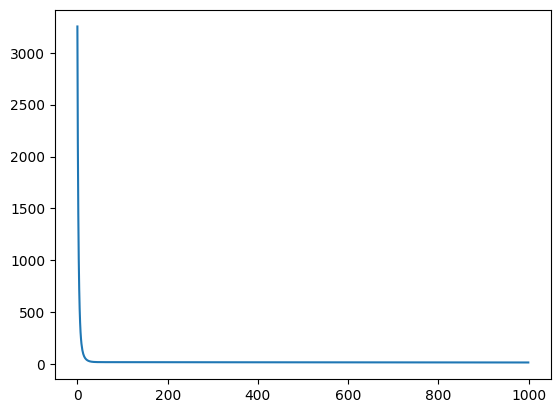

In [126]:
theta1 = torch.tensor(np.random.uniform(0, 2 * np.pi), requires_grad=True)
theta2 = torch.tensor(np.random.uniform(0, 2 * np.pi), requires_grad=True)
theta3 = torch.tensor(np.random.uniform(0, 2 * np.pi), requires_grad=True)

losses = []

draw_cake(center_point, theta1, theta2, theta3)

# optimizer = torch.optim.SGD([theta1_0, theta2_0, theta3_0], lr=0.0001)
optimizer = torch.optim.SGD([theta1, theta2, theta3], lr=0.00001)

for i in range(1000):
    # perim_loss = compute_loss(theta1, theta2, theta3)
    loss = compute_loss(theta1, theta2, theta3)

    print(f'Step {i}:')
    print(f'Theta 1: {theta1}')
    print(f'Theta 2: {theta2}')
    print(f'Theta 3: {theta3}')
    print(f'Loss :{float(loss.detach())}\n')

    losses += [loss.detach()]

    loss.backward()
    optimizer.step()
    optimizer.zero_grad(set_to_none=False)

plt.plot(losses)
plt.show()

draw_cake(center_point, theta1, theta2, theta3)